<a href="https://colab.research.google.com/github/s0han24/non_tabular_rl/blob/main/dqn_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
print(torch.cuda.is_available())

True


In [15]:
# # Check if MPS device is available
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")

In [16]:
# # Add device fallback logic
# def get_optimal_device():
#     if torch.backends.mps.is_available():
#         # Test performance with a simple operation
#         import time

#         # Test MPS
#         mps_device = torch.device("mps")
#         start = time.time()
#         x = torch.randn(1000, 1000, device=mps_device)
#         y = torch.mm(x, x)
#         torch.mps.synchronize()
#         mps_time = time.time() - start

#         # Test CPU
#         start = time.time()
#         x = torch.randn(1000, 1000, device="cpu")
#         y = torch.mm(x, x)
#         cpu_time = time.time() - start

#         # Use MPS only if it's significantly faster
#         if mps_time < cpu_time * 0.8:
#             print(f"Using MPS (MPS: {mps_time:.3f}s, CPU: {cpu_time:.3f}s)")
#             return mps_device
#         else:
#             print(f"Using CPU - MPS not faster (MPS: {mps_time:.3f}s, CPU: {cpu_time:.3f}s)")
#             return torch.device("cpu")
#     else:
#         return torch.device("cpu")

# device = get_optimal_device()

In [3]:
device = torch.device("cuda")

In [4]:
# Fix for numpy bool type deprecation
np.bool8 = np.bool

In [5]:
hidden_layer_size = 64
num_episodes = 100000
batch_size = 64
gamma = 0.99
initial_epsilon = 1.0
final_epsilon = 0.01

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        if isinstance(state, torch.Tensor):
            state = state.cpu().numpy()
        if isinstance(next_state, torch.Tensor):
            next_state = next_state.cpu().numpy()
        # Store the experience in the buffer as numpy arrays
        self.buffer[self.position] = (state, action, reward, next_state, done)
        # Increment the position and wrap around if necessary
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [7]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.fc3 = nn.Linear(hidden_layer_size, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
def choose_action(state, model, epsilon=0.05):
    if random.random() < epsilon:
        return random.randint(0, 1)  # Random action
    else:
        with torch.no_grad():
            # Convert to tensor only once
            if isinstance(state, torch.Tensor):
                if state.device != device:
                    state_tensor = state.to(device)
                else:
                    state_tensor = state
                if state_tensor.dim() == 1:
                    state_tensor = state_tensor.unsqueeze(0)
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = model(state_tensor)
            return q_values.argmax().item()

In [23]:
model = DQN(input_dim=4, output_dim=2)  # CartPole has 4 state dimensions and 2 actions
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
buffer = ReplayBuffer(capacity=10000)
env = gym.make('CartPole-v1')

model.to(device)

episode_returns = []
bellman_errors = []

# Value function at initial state
value_history = []

for episode in tqdm(range(num_episodes)):
    epsilon = (initial_epsilon - final_epsilon) * (num_episodes - episode) / num_episodes + final_epsilon

    episode_return = 0
    bellman_error = 0

    state, info = env.reset()
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    if episode % 100 == 0:
        with torch.no_grad():
            value_history.append(model(state_tensor).max().item())

    done = False
    while not done:
        action = choose_action(state, model, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        buffer.push(state, action, reward, next_state, done)
        state = next_state

        episode_return += reward

    if len(buffer) > batch_size:
        experiences = buffer.sample(batch_size)

        states, actions, rewards, next_states, dones = zip(*experiences)


        # Single efficient tensor conversion
        states = torch.FloatTensor(np.array(states)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = model(next_states).max(dim=1)[0]
        target_q_values = rewards + (1 - dones) * gamma * next_q_values

        loss = criterion(q_values, target_q_values.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bellman_error += loss.item()

    if episode % 100 == 0:
        episode_returns.append(episode_return)
        bellman_errors.append(bellman_error)

env.close()

100%|██████████| 20000/20000 [08:50<00:00, 37.69it/s]


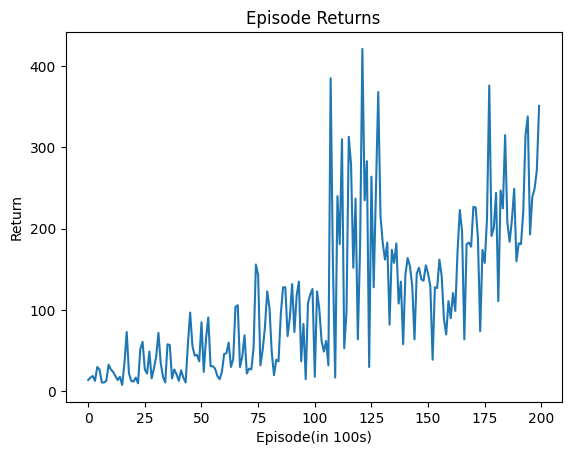

In [24]:
plt.plot(episode_returns)
plt.xlabel('Episode(in 100s)')
plt.ylabel('Return')
plt.title('Episode Returns')
plt.show()

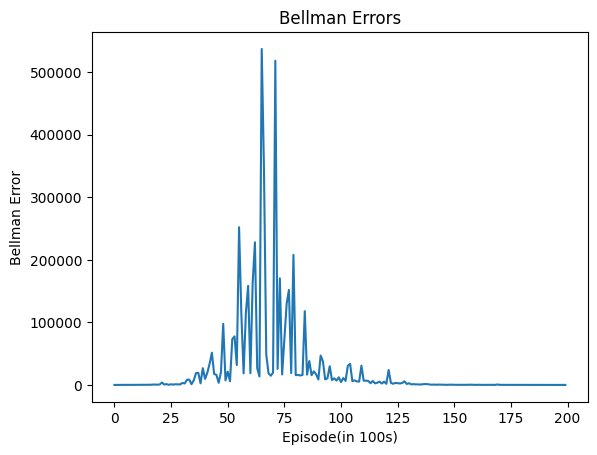

In [25]:
plt.plot(bellman_errors)
plt.xlabel('Episode(in 100s)')
plt.ylabel('Bellman Error')
plt.title('Bellman Errors')
plt.show()

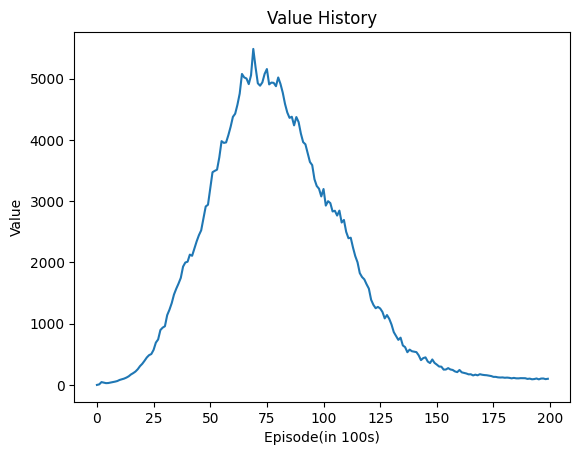

In [26]:
plt.plot(value_history)
plt.xlabel('Episode(in 100s)')
plt.ylabel('Value')
plt.title('Value History')
plt.show()

In [9]:
target_update_freq = 200

In [10]:
model = DQN(input_dim=4, output_dim=2)  # CartPole has 4 state dimensions and 2 actions
# Copy the model to target model
target_model = DQN(input_dim=4, output_dim=2)
target_model.load_state_dict(model.state_dict())
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
buffer = ReplayBuffer(capacity=10000)
env = gym.make('CartPole-v1')

model.to(device)
target_model.to(device)

episode_returns = []
bellman_errors = []

# Value function at initial state
value_history = []

for episode in tqdm(range(num_episodes)):
    epsilon = (initial_epsilon - final_epsilon) * (num_episodes - episode) / num_episodes + final_epsilon

    episode_return = 0
    bellman_error = 0

    state, info = env.reset()
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    if episode % 100 == 0:
        with torch.no_grad():
            value_history.append(model(state_tensor).max().item())

    if episode % target_update_freq == 0:
        target_model.load_state_dict(model.state_dict())

    done = False
    while not done:
        action = choose_action(state, model, epsilon)
        result = env.step(action)
        if len(result) == 5:
            next_state, reward, done, truncated, info = result
            done = done or truncated
        else:
            next_state, reward, done, info = result

        buffer.push(state, action, reward, next_state, done)
        state = next_state

        episode_return += reward

    if len(buffer) > batch_size:
        experiences = buffer.sample(batch_size)

        states, actions, rewards, next_states, dones = zip(*experiences)


        # Single efficient tensor conversion
        states = torch.FloatTensor(np.array(states)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = target_model(next_states).max(dim=1)[0]
        target_q_values = rewards + (1 - dones) * gamma * next_q_values

        loss = criterion(q_values, target_q_values.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bellman_error += loss.item()

    if episode % 100 == 0:
        episode_returns.append(episode_return)
        bellman_errors.append(bellman_error)

env.close()

100%|██████████| 100000/100000 [15:14<00:00, 109.32it/s]


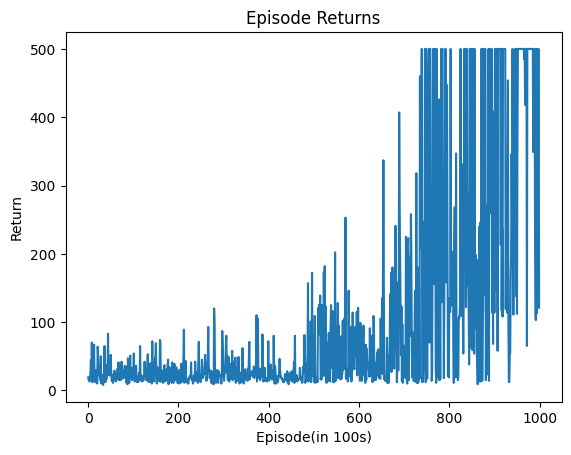

In [11]:
plt.plot(episode_returns)
plt.xlabel('Episode(in 100s)')
plt.ylabel('Return')
plt.title('Episode Returns')
plt.show()

### Note: When return hits 500, the episode gets truncated

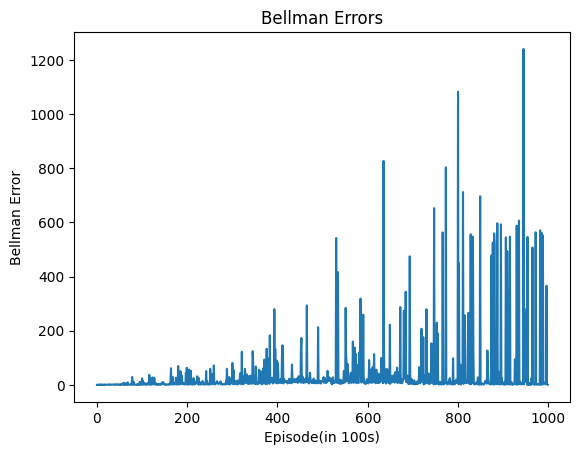

In [12]:
plt.plot(bellman_errors)
plt.xlabel('Episode(in 100s)')
plt.ylabel('Bellman Error')
plt.title('Bellman Errors')
plt.show()

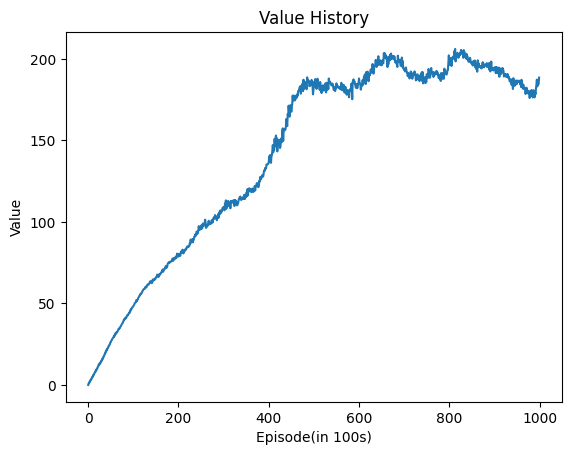

In [13]:
plt.plot(value_history)
plt.xlabel('Episode(in 100s)')
plt.ylabel('Value')
plt.title('Value History')
plt.show()